### Notes
- ~~Convert tf to torch~~
- ~~Use Bahadir's code~~
	- ~~Includes custom training scheduler~~
	- ~~Custom optimizer~~

In [1]:
from torch.utils.data import DataLoader, Subset
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
import torchvision.transforms as transforms
import os
import pickle
from time import time
from tqdm.auto import tqdm
import torch
from resnet import ResNet34
import math

##### Load Data

In [2]:
NUM_MODELS = 5
EPOCHS = 30
NUM_TRAIN_SAMPLES = 50000
datasizes = np.logspace(math.log10(50000.1), math.log10(4900), 20, base=10).astype(int)
datasizes

array([50000, 44246, 39154, 34648, 30661, 27133, 24011, 21247, 18802,
       16639, 14724, 13029, 11530, 10203,  9029,  7990,  7070,  6257,
        5537,  4900])

In [3]:
device = 'cuda'

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
TEST_LOADER = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

trainset_nocrop_noflip = CIFAR10(root='./data', train=True, download=True, transform=transform_test)
trainloader_for_Jacobian  = DataLoader(trainset_nocrop_noflip, batch_size=1, shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


##### Define functions

In [4]:
# Model
def create_model():
	net = ResNet34()
	net = net.to(device)
	if device == 'cuda':
		net = torch.nn.DataParallel(net)
		cudnn.benchmark = True
	return net

In [5]:
def train_new(epochs: int, train_loader) -> torch.nn.DataParallel:
	# new model
	model = create_model()
      
	# setup optimizer + schedulers
	optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
	scheduler1  = CosineAnnealingLR(optimizer, T_max=20000)
	scheduler2 = LinearLR(optimizer, start_factor=0.0001, end_factor=1.0, total_iters=2500)
	scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[2500])
  
	# train model
	for epoch in range(epochs):
		acc = train(model, scheduler, optimizer, train_loader)
		#print(f'Epoch {epoch + 1} / {epochs} --\taccuracy: {acc:.5f}')
	
	return model

def train(net: torch.nn.DataParallel, scheduler: SequentialLR, optimizer: torch.optim.SGD, train_loader: DataLoader) -> float:
	net.train()
	train_loss = 0
	correct = 0
	total = 0
	no_of_training_steps = 0
	for inputs, targets in train_loader:
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = net(inputs)
		loss = criterion(outputs, targets)
		loss.backward()
		optimizer.step()

		train_loss += loss.item()
		_, predicted = outputs.max(1)
		total += targets.size(0)
		correct += predicted.eq(targets).sum().item()
		no_of_training_steps = no_of_training_steps + 1

		scheduler.step()

	return correct / total

def save_model(model: torch.nn.DataParallel, path: str):
	print('Saving..')
	parts = path.split('/')
	if len(parts) == 2 and not os.path.isdir(parts[0]):
		os.mkdir(parts[0])
	state = model.state_dict()
	torch.save(state, path)

def test(net: torch.nn.DataParallel) -> float:
	net.eval()
	test_loss = 0
	correct = 0
	total = 0
	with torch.no_grad():
		for batch_idx, (inputs, targets) in enumerate(TEST_LOADER):
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = net(inputs)
			loss = criterion(outputs, targets)

			test_loss += loss.item()
			_, predicted = outputs.max(1)
			total += targets.size(0)
			correct += predicted.eq(targets).sum().item()

	return 100.*correct/total

	print('test',100.*correct/total, correct, total)
	# if acc > best_acc:
	# 	print('Saving..')
	# 	state = {
	# 		'net': net.state_dict(),
	# 		'acc': acc
	# 	}
	# 	if not os.path.isdir('checkpoint'):
	# 		os.mkdir('checkpoint')
	# 	torch.save(state, './checkpoint/ckpt.pth')
	# 	best_acc = acc

In [7]:
def plot_accuracies(accuracies: list[float], names: list[str]=None):
  plt.figure(figsize=(14, 10))
  for acclist in accuracies:
    plt.plot(np.linspace(100, 100 * datasizes_close_up[-1] / datasizes_close_up[0], datasizes_close_up.shape[0]).round().astype('int'), np.mean(acclist, axis=1))

  if names is not None:
    plt.legend(names, fontsize=11)

  plt.xlabel('Percentage of Dataset Used in Training (%)')
  plt.ylabel(f'Average Model Test Accuracy (n={NUM_MODELS})')
  plt.grid()
  plt.gca().invert_xaxis()
  plt.show()

In [8]:
def save_to_file(path: str, obj):
	path_components = path.split('/')

	built_path = ''
	for component in path_components[:-1]:
		built_path += component + '/'
		if not os.path.exists(built_path):
			os.mkdir(built_path)

	with open(path, 'wb') as file:
		pickle.dump(obj, file)
		file.close()

In [9]:
# 30 epochs ~ 12.5 min 93.75% accuracy
#model = train_new(30, DataLoader(trainset, batch_size=128, sampler=sampler, num_workers=2))

model = create_model()

In [10]:
# save_model(model, 'temp/model_weights')
with open('./temp/model_weights', 'rb') as file:
	weights = torch.load(file)
	file.close()
	del file
model.load_state_dict(weights)
# nt.load_weights('./temp/model_weights')

<All keys matched successfully>

##### get jacobian norms of network per data point

In [ ]:
# takes ~7 min
jacobian_norms = []
for inputs, labels in tqdm(trainloader_for_Jacobian):
  start = time()
  jacobian: torch.Tensor = torch.autograd.functional.jacobian(lambda x: criterion(model(x), labels.to(device)), inputs.to(device))
  jacobian_norms.append(np.linalg.norm(jacobian.to("cpu")))

jacobian_norms = np.array(jacobian_norms)

  0%|          | 0/50000 [00:03<?, ?it/s]

In [11]:
with open('./temp/jacobian_norms', 'rb') as file:
  jacobian_norms = pickle.load(file)
  file.close()
  del file
# with open('./temp/jacobian_norms', 'wb') as file:
#   pickle.dump(jacobian_norms, file)
#   file.close()
#   del file

##### reduce dataset by Jacobian norm

In [30]:
jac_val_acc: list[list[float]] = []
for data_size_idx, data_size in enumerate(datasizes):
	keep_indices = np.argsort(jacobian_norms)[-data_size:]
	trainset_reduced = Subset(trainset, keep_indices)
	
	train_loader = DataLoader(trainset_reduced, batch_size=128, shuffle=True, num_workers=2)
	print(f'Dataset size: {data_size} ({100* data_size / datasizes[0]:.0f}% of dataset)')

	jac_val_acc.append([])
	for model_idx in range(NUM_MODELS):
		# check if progress is saved for this datasize + model
		prog_path = f'temp/prog/jacobian/datasize_{data_size}_model_{model_idx}'
		if os.path.exists(prog_path):
			with open(prog_path, 'rb') as file:
				valacc = pickle.load(file)
				file.close()
			jac_val_acc[-1].append(valacc)
			print(f'Previous model accuracy found at "{prog_path}", skipping computation. (To overwrite previous accuracies set `overwrite`=True)')
			continue

		# train model and get validation accuracy
		_model = train_new(EPOCHS, train_loader)
		test_acc = test(_model)
		print(f"data size: {data_size}, model: {model_idx + 1} val acc = {test_acc}")
		jac_val_acc[-1].append(test_acc)
		save_to_file(prog_path, test_acc)

Dataset size: 50000 (100% of dataset)


c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


data size: 50000, model: 1 val acc = 87.46
data size: 50000, model: 2 val acc = 85.85
data size: 50000, model: 3 val acc = 88.12
data size: 50000, model: 4 val acc = 87.96
data size: 50000, model: 5 val acc = 88.0
Dataset size: 44246 (88% of dataset)
data size: 44246, model: 1 val acc = 82.68
data size: 44246, model: 2 val acc = 86.38
data size: 44246, model: 3 val acc = 87.25
data size: 44246, model: 4 val acc = 87.57


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001A1EDA68C10>
Traceback (most recent call last):
  File "c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


data size: 44246, model: 5 val acc = 87.39
Dataset size: 39154 (78% of dataset)
data size: 39154, model: 1 val acc = 79.38
data size: 39154, model: 2 val acc = 83.87
data size: 39154, model: 3 val acc = 84.86
data size: 39154, model: 4 val acc = 82.6
data size: 39154, model: 5 val acc = 85.81
Dataset size: 34648 (69% of dataset)
data size: 34648, model: 1 val acc = 83.63
data size: 34648, model: 2 val acc = 84.07
data size: 34648, model: 3 val acc = 84.96
data size: 34648, model: 4 val acc = 82.84
data size: 34648, model: 5 val acc = 82.18
Dataset size: 30661 (61% of dataset)
data size: 30661, model: 1 val acc = 80.99
data size: 30661, model: 2 val acc = 81.05
data size: 30661, model: 3 val acc = 79.83
data size: 30661, model: 4 val acc = 78.8
data size: 30661, model: 5 val acc = 79.9
Dataset size: 27133 (54% of dataset)
data size: 27133, model: 1 val acc = 74.37
data size: 27133, model: 2 val acc = 74.9
data size: 27133, model: 3 val acc = 76.09
data size: 27133, model: 4 val acc = 75

##### reduce dataset randomly

In [38]:
random_val_acc: list[list[float]] = []
for data_size_idx, data_size in enumerate(datasizes):
	keep_indices = np.random.choice(NUM_TRAIN_SAMPLES, data_size, replace=False)
	trainset_reduced = Subset(trainset, keep_indices)
	train_loader = DataLoader(trainset_reduced, batch_size=128, shuffle=True, num_workers=2)
	print(f'Dataset size: {data_size} ({100* data_size / datasizes[0]:.0f}% of dataset)')

	random_val_acc.append([])
	for model_idx in range(NUM_MODELS):
		# check if progress is saved for this datasize + model
		prog_path = f'temp/prog/rand/datasize_{data_size}_model_{model_idx}'
		if os.path.exists(prog_path):
			with open(prog_path, 'rb') as file:
				valacc = pickle.load(file)
				file.close()
			random_val_acc[-1].append(valacc)
			print(f'Previous model accuracy found at "{prog_path}", skipping computation. (To overwrite previous accuracies set `overwrite`=True)')
			continue

		# train model and get validation accuracy
		_model = train_new(EPOCHS, train_loader)
		test_acc = test(_model)
		print(f"data size: {data_size}, model: {model_idx + 1} val acc = {test_acc}")
		random_val_acc[-1].append(test_acc)
		save_to_file(prog_path, test_acc)

Dataset size: 50000 (100% of dataset)


c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


data size: 50000, model: 1 val acc = 88.33
data size: 50000, model: 2 val acc = 87.94
data size: 50000, model: 3 val acc = 88.92
data size: 50000, model: 4 val acc = 86.91
data size: 50000, model: 5 val acc = 87.78
Dataset size: 44246 (88% of dataset)
data size: 44246, model: 1 val acc = 85.92
data size: 44246, model: 2 val acc = 87.9
data size: 44246, model: 3 val acc = 86.87
data size: 44246, model: 4 val acc = 87.45
data size: 44246, model: 5 val acc = 86.2
Dataset size: 39154 (78% of dataset)
data size: 39154, model: 1 val acc = 86.29
data size: 39154, model: 2 val acc = 84.47
data size: 39154, model: 3 val acc = 87.41
data size: 39154, model: 4 val acc = 85.48
data size: 39154, model: 5 val acc = 84.84
Dataset size: 34648 (69% of dataset)
data size: 34648, model: 1 val acc = 85.16
data size: 34648, model: 2 val acc = 85.69
data size: 34648, model: 3 val acc = 84.6
data size: 34648, model: 4 val acc = 85.56
data size: 34648, model: 5 val acc = 85.77
Dataset size: 30661 (61% of data

### Dataset is reduced by keeping HIGHEST n% of dataset based on given metric

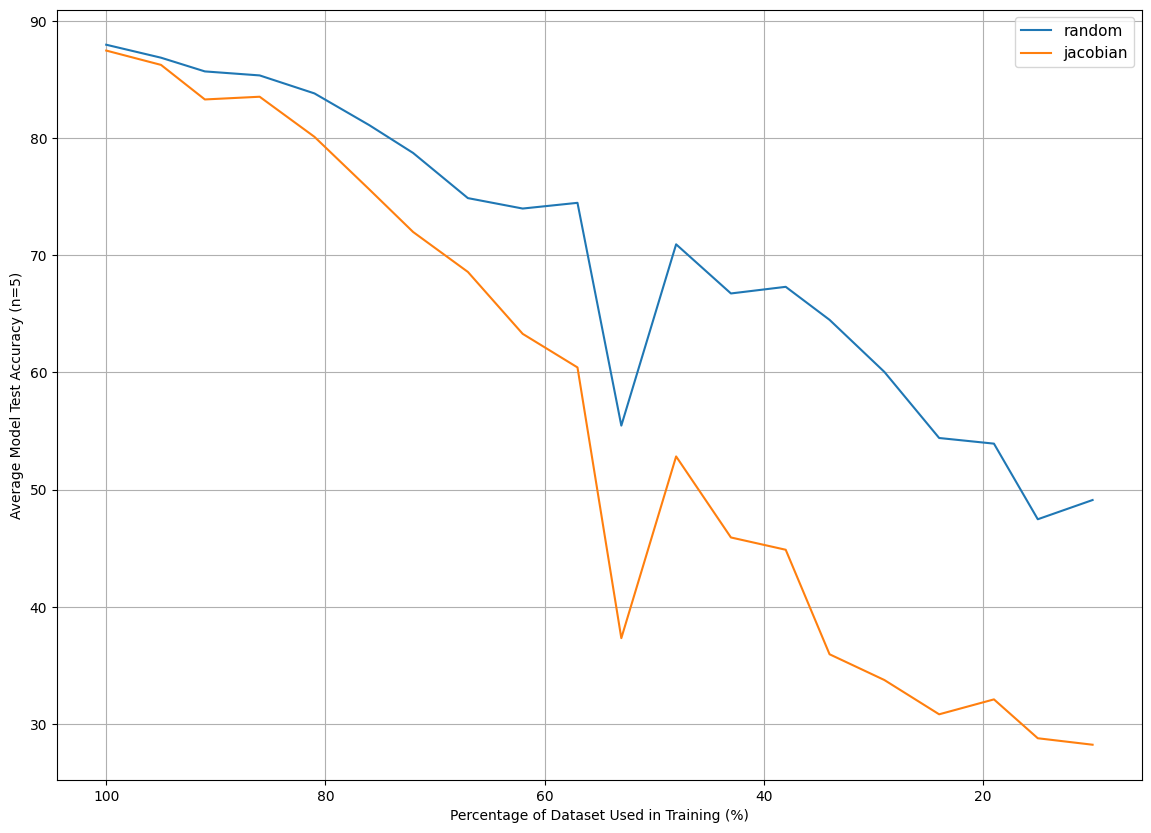

In [39]:
plot_accuracies([random_val_acc, jac_val_acc], names=['random', 'jacobian'])

In [9]:
datasizes_close_up = np.linspace(50000, 0.75 * 50000, 12).astype(int)
datasizes_close_up

array([50000, 48863, 47727, 46590, 45454, 44318, 43181, 42045, 40909,
       39772, 38636, 37500])

In [12]:
jac_val_acc_close: list[list[float]] = []
for data_size_idx, data_size in enumerate(datasizes_close_up):
	keep_indices = np.argsort(jacobian_norms)[-data_size:]
	trainset_reduced = Subset(trainset, keep_indices)
	
	train_loader = DataLoader(trainset_reduced, batch_size=128, shuffle=True, num_workers=2)
	print(f'Dataset size: {data_size} ({100* data_size / datasizes_close_up[0]:.0f}% of dataset)')

	jac_val_acc_close.append([])
	for model_idx in range(NUM_MODELS):
		# check if progress is saved for this datasize + model
		prog_path = f'temp/prog/jacobian/datasize_{data_size}_model_{model_idx}'
		if os.path.exists(prog_path):
			with open(prog_path, 'rb') as file:
				valacc = pickle.load(file)
				file.close()
			jac_val_acc_close[-1].append(valacc)
			print(f'Previous model accuracy found at "{prog_path}", skipping computation. (To overwrite previous accuracies set `overwrite`=True)')
			continue

		# train model and get validation accuracy
		_model = train_new(EPOCHS, train_loader)
		test_acc = test(_model)
		print(f"data size: {data_size}, model: {model_idx + 1} val acc = {test_acc}")
		jac_val_acc_close[-1].append(test_acc)
		save_to_file(prog_path, test_acc)

Dataset size: 50000 (100% of dataset)


c:\Users\Nico\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


data size: 50000, model: 1 val acc = 85.75
data size: 50000, model: 2 val acc = 88.24
data size: 50000, model: 3 val acc = 88.12
data size: 50000, model: 4 val acc = 85.81
data size: 50000, model: 5 val acc = 87.53
Dataset size: 48863 (98% of dataset)
data size: 48863, model: 1 val acc = 87.95
data size: 48863, model: 2 val acc = 85.2
data size: 48863, model: 3 val acc = 88.81
data size: 48863, model: 4 val acc = 85.91
Previous model accuracy found at "temp/prog/jacobian/datasize_48863_model_4", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Dataset size: 47727 (95% of dataset)
Previous model accuracy found at "temp/prog/jacobian/datasize_47727_model_0", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "temp/prog/jacobian/datasize_47727_model_1", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "temp/prog/jacobian/datasize_47727_mode

In [13]:
random_val_acc_close: list[list[float]] = []
for data_size_idx, data_size in enumerate(datasizes_close_up):
	keep_indices = np.random.choice(NUM_TRAIN_SAMPLES, data_size, replace=False)
	trainset_reduced = Subset(trainset, keep_indices)
	train_loader = DataLoader(trainset_reduced, batch_size=128, shuffle=True, num_workers=2)
	print(f'Dataset size: {data_size} ({100* data_size / datasizes_close_up[0]:.0f}% of dataset)')

	random_val_acc_close.append([])
	for model_idx in range(NUM_MODELS):
		# check if progress is saved for this datasize + model
		prog_path = f'temp/prog/rand/datasize_{data_size}_model_{model_idx}'
		if os.path.exists(prog_path):
			with open(prog_path, 'rb') as file:
				valacc = pickle.load(file)
				file.close()
			random_val_acc_close[-1].append(valacc)
			print(f'Previous model accuracy found at "{prog_path}", skipping computation. (To overwrite previous accuracies set `overwrite`=True)')
			continue

		# train model and get validation accuracy
		_model = train_new(EPOCHS, train_loader)
		test_acc = test(_model)
		print(f"data size: {data_size}, model: {model_idx + 1} val acc = {test_acc}")
		random_val_acc_close[-1].append(test_acc)
		save_to_file(prog_path, test_acc)

Dataset size: 50000 (100% of dataset)
Previous model accuracy found at "temp/prog/rand/datasize_50000_model_0", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "temp/prog/rand/datasize_50000_model_1", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "temp/prog/rand/datasize_50000_model_2", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "temp/prog/rand/datasize_50000_model_3", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous model accuracy found at "temp/prog/rand/datasize_50000_model_4", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Dataset size: 48863 (98% of dataset)
Previous model accuracy found at "temp/prog/rand/datasize_48863_model_0", skipping computation. (To overwrite previous accuracies set `overwrite`=True)
Previous mode

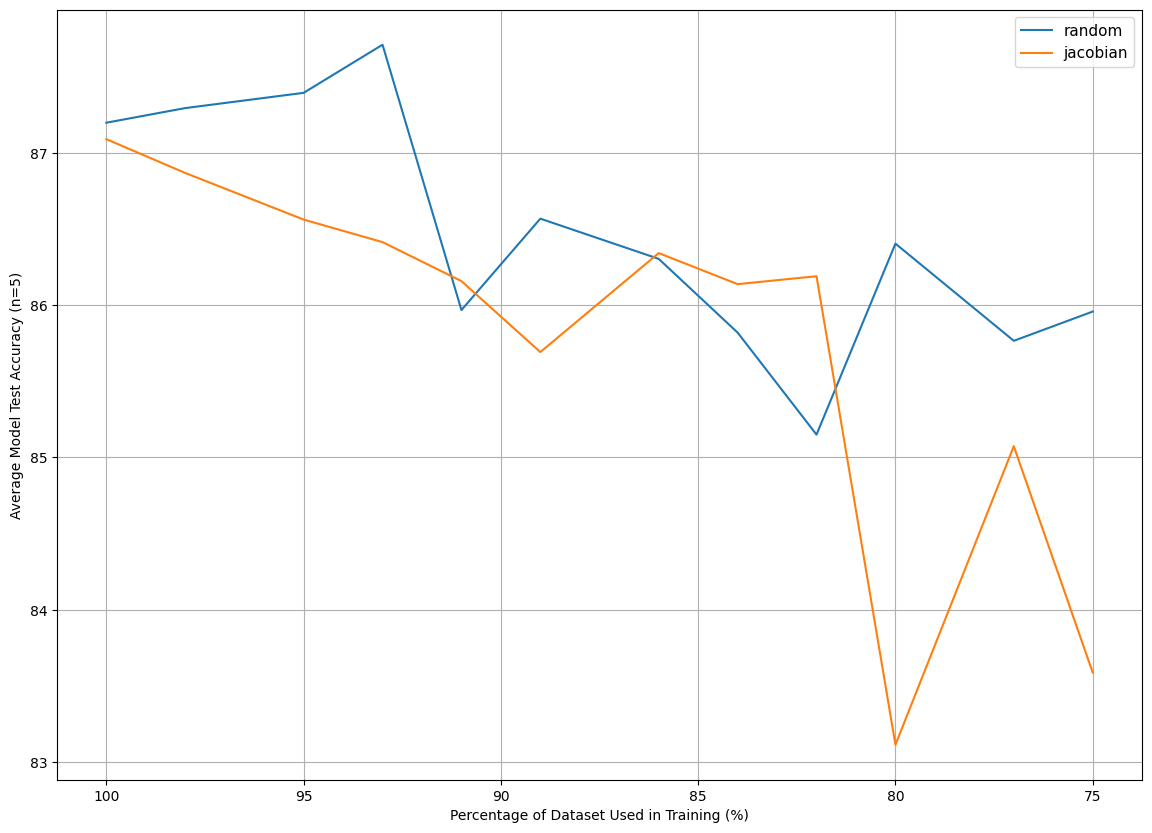

In [14]:
# this graph is gonna be messed up
# need to plot x-scale based on new datasizes list, not old one
plot_accuracies([random_val_acc_close, jac_val_acc_close], names=['random', 'jacobian'])